In [1]:
pwd

'/Users/kentasuzuki/kaggle/cancer/work-space/keras'

In [2]:
ls

Untitled.ipynb                   keras-first attempt.ipynb
Untitled1.ipynb                  metastore_db/
derby.log                        naive_first_1.h5
keras-first attempt-Copy1.ipynb  sum.csv


In [3]:
from keras.models import load_model

Using TensorFlow backend.


In [146]:
model = load_model('naive_first_1.h5')

In [147]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)         147584    
__________

In [149]:
# Preprocessing a single image
img_path = '/Volumes/kenta/datasets/cancer/test/0.jpg'

In [150]:
# preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
print(img_tensor.shape)

(64, 64, 3)


In [151]:
img_tensor = np.expand_dims(img_tensor, axis=0)
# I traned the model on the inputs that were rescaled by 255
img_tensor /= 255

print(img_tensor.shape)

(1, 64, 64, 3)


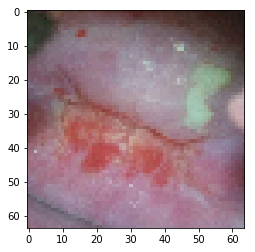

In [152]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])

In [153]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Create a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [154]:
activations = activation_model.predict(img_tensor)

In [155]:
# First entry in the outputs: 
# the output of the first layer of the original model
first_layer_activation = activations[0]
# 64x64 feature map with 32 channels
print(first_layer_activation.shape)

(1, 62, 62, 32)


In [157]:
len(activations)

8

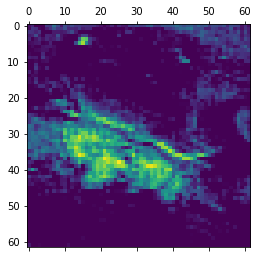

In [156]:
# 1st of activatiion of the first layer on the test cervix picture
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

(1, 29, 29, 64)


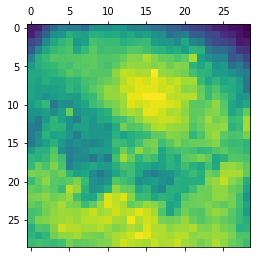

In [162]:
# First entry in the outputs: 
# the output of the third layer of the original model
third_layer_activation = activations[2]
# 64x64 feature map with 32 channels
print(third_layer_activation.shape)


# last of activatiion of the first layer on the test cervix picture
plt.matshow(third_layer_activation[0, :, :, 2], cmap='viridis')

(1, 2, 2, 128)


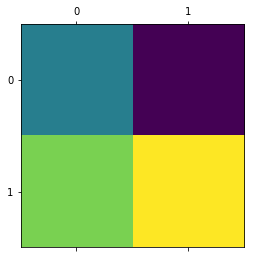

In [163]:
# First entry in the outputs: 
# the output of the last layer of the original model
last_layer_activation = activations[-1]
# 64x64 feature map with 32 channels
print(last_layer_activation.shape)


# last of activatiion of the last layer on the test cervix picture
plt.matshow(last_layer_activation[0, :, :, 2], cmap='viridis')

In [44]:
from keras import layers

In [148]:
model.layers

the number of convolutional layers is:  4


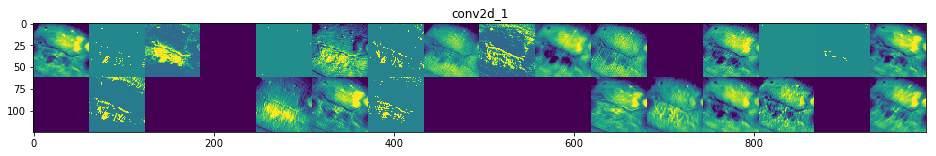

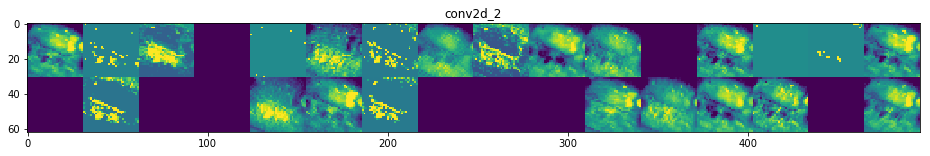

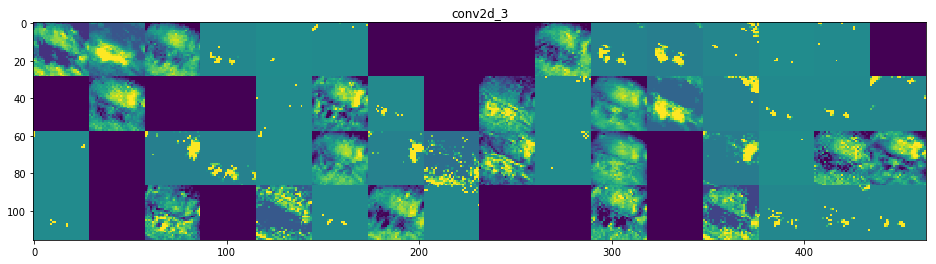

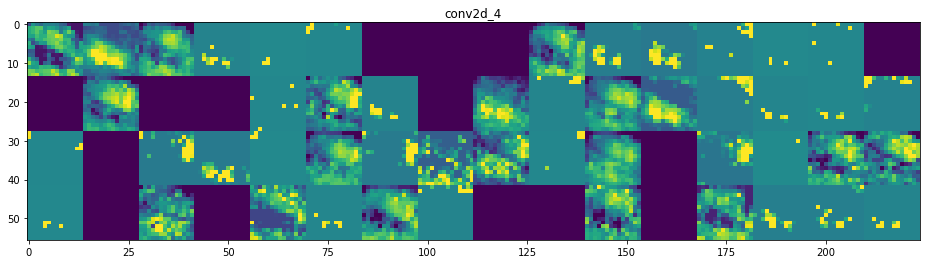

In [65]:
# visualizing every channle in every intermediate activation
layer_names = []
for layer in model.layers[:8]:
    if isinstance(layer, layers.Conv2D):
        layer_names.append(layer.name)

print("the number of convolutional layers is: ", len(layer_names))

images_per_row = 16

# Display the feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]
    # This will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    # This will tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1)
                        * size] = channel_image
    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
            

In [48]:
layer_names[0]

'conv2d_1'

In [52]:
activations[-1].shape[-1]

128

In [58]:
display_grid.shape

(56, 224)

In [71]:
import keras.backend as K

In [72]:
# Define the loss tensor for filter visualization
layer_name = 'conv2d_1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [73]:
layer_output

<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 62, 62, 32) dtype=float32>

In [74]:
loss

<tf.Tensor 'Mean_4:0' shape=() dtype=float32>

In [75]:
grads = K.gradients(loss, model.input)[0]

In [76]:
grads

<tf.Tensor 'gradients_1/conv2d_1/convolution_grad/Conv2DBackpropInput:0' shape=(?, 64, 64, 3) dtype=float32>

In [78]:
 K.gradients(loss, model.input)[0]

<tf.Tensor 'gradients_3/conv2d_1/convolution_grad/Conv2DBackpropInput:0' shape=(?, 64, 64, 3) dtype=float32>

In [79]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [81]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 64, 64, 3))])

In [83]:
input_img_data = np.random.random((1, 64, 64, 3)) * 20 + 128

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [92]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    
    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [93]:
def generate_pattern(layer_name, filter_index, size=64):
    # build a loss function that maximize the activation
    # of the nth filter of the layer considered 
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    # compute the gradient of the input picture
    grads = K.gradients(loss, model.input)[0]
    
    # normalization trick: we normalize the gradient 
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # this function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise 
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    # run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

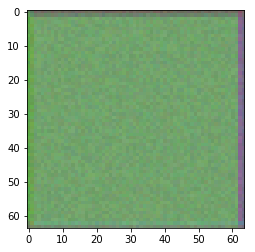

In [94]:
plt.imshow(generate_pattern("conv2d_1", 0))

In [97]:
layer_name = 'conv2d_1'
size = 64
margin = 5

# this is an empty (black) image where we will store our results
results = np.zeros((8 * size + 7 * margin,  8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start:horizontal_end, vertical_start:vertical_end, :] =  filter_img
        
# display the result grid
plt.figure(figsize=(20, 20))
plt.imshow(results)

ValueError: slice index 32 of dimension 3 out of bounds. for 'strided_slice_10' (op: 'StridedSlice') with input shapes: [?,62,62,32], [4], [4], [4].

In [138]:
from keras.preprocessing import image 
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

In [139]:
model = VGG16(weights='imagenet')

In [143]:
img = image.load_img(img_path, target_size=(224,224))


# 'x' is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# add a dimension to transform the array into a "batch"
# of size (1, 64, 64, 3)
x = np.expand_dims(x, axis=0)

x = preprocess_input(x)

In [144]:
x.shape

(1, 224, 224, 3)

In [145]:
preds = model.predict(x)
print("Predicted: ", decode_predictions(preds, top=3)[0])

Predicted:  [('n01632777', 'axolotl', 0.86517262), ('n07614500', 'ice_cream', 0.0085596191), ('n07615774', 'ice_lolly', 0.0071726078)]


In [132]:
model.predict(x, batch_size=1)

array([[ 0.24110535,  0.34810403,  0.41079062]], dtype=float32)

In [135]:
np.argmax(model.predict(x, batch_size=1))

2

In [133]:
# since there is largest probability for type3 on image 1 on test set
# visualize use which parts of the images were the most 'type_3_like'
type_3_output = model.output[:, 2]
# the last convolutional layer in the model I trained
last_conv_layer = model.get_layer('conv2d_4')

grads = K.gradients(type_3_output, last_conv_layer.output)[0]


pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])


In [134]:
pooled_grads_value, conv_layer_output_value = iterate([x])

InvalidArgumentError: You must feed a value for placeholder tensor 'dropout_1/keras_learning_phase' with dtype bool
	 [[Node: dropout_1/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'dropout_1/keras_learning_phase', defined at:
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-e4abaceaf55d>", line 1, in <module>
    model = load_model('naive_first_1.h5')
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/models.py", line 232, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/models.py", line 293, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/layers/__init__.py", line 46, in deserialize
    printable_module_name='layer')
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/utils/generic_utils.py", line 141, in deserialize_keras_object
    return cls.from_config(config['config'])
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/models.py", line 1190, in from_config
    model.add(layer)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/models.py", line 455, in add
    output_tensor = layer(self.outputs[0])
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/engine/topology.py", line 554, in __call__
    output = self.call(inputs, **kwargs)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/layers/core.py", line 111, in call
    training=training)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 2403, in in_train_phase
    training = learning_phase()
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 102, in learning_phase
    name='keras_learning_phase')
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1502, in placeholder
    name=name)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'dropout_1/keras_learning_phase' with dtype bool
	 [[Node: dropout_1/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [118]:
x

array([[[[-64.93900299, -70.77899933, -80.68000031],
         [-62.93900299, -70.77899933, -76.68000031],
         [-51.93900299, -68.77899933, -69.68000031],
         ..., 
         [-80.93900299, -90.77899933, -83.68000031],
         [-80.93900299, -90.77899933, -83.68000031],
         [-76.93900299, -87.77899933, -84.68000031]],

        [[-63.93900299, -67.77899933, -77.68000031],
         [-69.93900299, -69.77899933, -78.68000031],
         [-61.93900299, -63.77899933, -72.68000031],
         ..., 
         [-77.93900299, -88.77899933, -85.68000031],
         [-83.93900299, -93.77899933, -92.68000031],
         [-80.93900299, -91.77899933, -88.68000031]],

        [[-63.93900299, -62.77899933, -75.68000031],
         [-63.93900299, -65.77899933, -75.68000031],
         [-63.93900299, -65.77899933, -75.68000031],
         ..., 
         [-75.93900299, -88.77899933, -81.68000031],
         [-81.93900299, -88.77899933, -88.68000031],
         [-82.93900299, -92.77899933, -91.68000031

In [117]:
pooled_grads_value, conv_layer_output_value = iterate([x])

InvalidArgumentError: You must feed a value for placeholder tensor 'dropout_1/keras_learning_phase' with dtype bool
	 [[Node: dropout_1/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'dropout_1/keras_learning_phase', defined at:
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-e4abaceaf55d>", line 1, in <module>
    model = load_model('naive_first_1.h5')
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/models.py", line 232, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/models.py", line 293, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/layers/__init__.py", line 46, in deserialize
    printable_module_name='layer')
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/utils/generic_utils.py", line 141, in deserialize_keras_object
    return cls.from_config(config['config'])
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/models.py", line 1190, in from_config
    model.add(layer)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/models.py", line 455, in add
    output_tensor = layer(self.outputs[0])
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/engine/topology.py", line 554, in __call__
    output = self.call(inputs, **kwargs)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/layers/core.py", line 111, in call
    training=training)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 2403, in in_train_phase
    training = learning_phase()
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 102, in learning_phase
    name='keras_learning_phase')
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1502, in placeholder
    name=name)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'dropout_1/keras_learning_phase' with dtype bool
	 [[Node: dropout_1/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [108]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)         147584    
__________